---
layout: post
title:  "Overengineering the quantified self: get that Fitbit"
date:   2019-07-27
categories: jekyll update
---

## Step 1: Register your personal app with Fitbit and grab the creds

### First, let's rig up your fitbit app

We'll follow along the steps listed in this [this blog post](https://towardsdatascience.com/collect-your-own-fitbit-data-with-python-ff145fa10873). 
1. Start by logging in to https://dev.fitbit.com/apps
1. Now register a new app using the configuration suggested by the post
1. Navigate to the details of your newfangled app and grab its client id and secret

In [1]:
import yaml
with open("/Users/luke.armistead/quantified_self_creds.yaml", 'r') as stream:
    creds = yaml.safe_load(stream)
CLIENT_ID = creds['fitbit']['client_id']
CLIENT_SECRET = creds['fitbit']['client_secret']

### Next, grab the access and refresh tokens

Clone a fancy fitbit oauth package into your directory and install its dependencies

In [2]:
!git clone https://github.com/orcasgit/python-fitbit
!pip3 install python-fitbit/requirements/base.txt

fatal: destination path 'python-fitbit' already exists and is not an empty directory.
ERROR: Invalid requirement: 'python-fitbit/requirements/base.txt'
It looks like a path. It does exist. The argument you provided (python-fitbit/requirements/base.txt) appears to be a requirements file. If that is the case, use the '-r' flag to install the packages specified within it.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip3 install --upgrade requests-oauthlib==1.1.0 oauthlib==2.1.0

Requirement already up-to-date: requests-oauthlib==1.1.0 in /Users/luke.armistead/.pyenv/versions/3.6.3/envs/py3/lib/python3.6/site-packages (1.1.0)
Requirement already up-to-date: oauthlib==2.1.0 in /Users/luke.armistead/.pyenv/versions/3.6.3/envs/py3/lib/python3.6/site-packages (2.1.0)
You should consider upgrading via the 'pip install --upgrade pip' command.


Mosey over to a directory where you can import the dynamite `gather_keys_oauth2` package to get your access and refresh tokens.

In [4]:
cd python-fitbit

/Users/luke.armistead/workspace/projects/lukearmistead.github.io/notebooks/python-fitbit


In [5]:
from gather_keys_oauth2 import *

/Users/luke.armistead/.pyenv/versions/py3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


And grab 'em! 

If you're like me, you hit a 500 error. [Fitbit forums suggest](https://community.fitbit.com/t5/Web-API-Development/Invalid-Client-Error/td-p/3290376) and my experience corroborates that you can get around this by downgrading to `requests-oauthlib==1.1.0` and `oauthlib==2.1.0`.

In [6]:
server = OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
keys = server.fitbit.client.session.token
ACCESS_TOKEN, REFRESH_TOKEN = str(keys['access_token']), str(keys['refresh_token'])

[16/Aug/2019:00:31:13] ENGINE Listening for SIGTERM.
[16/Aug/2019:00:31:13] ENGINE Listening for SIGHUP.
[16/Aug/2019:00:31:13] ENGINE Listening for SIGUSR1.
[16/Aug/2019:00:31:13] ENGINE Bus STARTING
CherryPy Checker:
The Application mounted at '' has an empty config.

[16/Aug/2019:00:31:13] ENGINE Started monitor thread 'Autoreloader'.
[16/Aug/2019:00:31:13] ENGINE Serving on http://127.0.0.1:8080
[16/Aug/2019:00:31:13] ENGINE Bus STARTED


127.0.0.1 - - [16/Aug/2019:00:31:45] "GET /?code=1f3bdd91b54c521c5ede7495c3f888fc28ef79d8&state=4tk4l1LhVwsW1wzzz2q3PPtjXMwGlX HTTP/1.1" 200 122 "" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.87 Safari/537.36"


[16/Aug/2019:00:31:46] ENGINE Bus STOPPING


127.0.0.1 - - [16/Aug/2019:00:31:47] "GET /favicon.ico HTTP/1.1" 200 1406 "http://127.0.0.1:8080/?code=1f3bdd91b54c521c5ede7495c3f888fc28ef79d8&state=4tk4l1LhVwsW1wzzz2q3PPtjXMwGlX" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/76.0.3809.87 Safari/537.36"


[16/Aug/2019:00:31:51] ENGINE HTTP Server cherrypy._cpwsgi_server.CPWSGIServer(('127.0.0.1', 8080)) shut down
[16/Aug/2019:00:31:51] ENGINE Stopped thread 'Autoreloader'.
[16/Aug/2019:00:31:51] ENGINE Bus STOPPED
[16/Aug/2019:00:31:51] ENGINE Bus EXITING
[16/Aug/2019:00:31:51] ENGINE Bus EXITED
[16/Aug/2019:00:31:51] ENGINE Waiting for child threads to terminate...


Import the stuff

## Step 2: Get your data

In [7]:
import fitbit
import pandas as pd 
import datetime
from datetime import datetime, timedelta

In [8]:
# TODO: Remove creds
client = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN)

In [9]:
today = datetime.datetime.now()
yr, mo, dy = today.year, today.month, today.day
yesterday =datetime.datetime(yr, mo, dy - 1)


AttributeError: type object 'datetime.datetime' has no attribute 'datetime'

API guide: https://dev.fitbit.com/build/reference/web-api/heart-rate/

### First plot

Too many requests: https://community.fitbit.com/t5/Web-API-Development/Too-many-request/td-p/1644362

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 500
random_x = np.linspace(0, 1, N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = df['dt'],
    y = df['active_minutes']
)

data = [trace]

py.iplot(data, filename='basic-line')

NameError: name 'df' is not defined

TODO: [Smooth lines](https://stackoverflow.com/questions/38274102/is-there-any-way-to-make-a-plotly-scatter-have-smooth-lines-connecting-points)

# Trying for sleep

In [17]:
hearts = client.time_series(resource='activities/heart', base_date='2019-04-01', end_date='2019-07-06')

In [18]:
sleeps = client.time_series(resource='sleep', base_date='2019-04-01', end_date='2019-07-06')

In [19]:
activities = client.time_series(resource='activities/distance', base_date='2019-04-01', end_date='2019-07-06')

In [20]:
activities = client.activities(date='2019-07-03')

In [21]:
df = pd.DataFrame(
    pd.date_range(start='2019-04-01', end=pd.datetime.today())
    ).rename(columns={0: 'dt'})
df['dt'] = pd.to_datetime(df['dt']).dt.date

In [22]:
fat_burns = []
cardios = []
peaks = []
resting_hr = []
dts = []
heart_rates = list(hearts['activities-heart'])
for entry in heart_rates:
    dts.append(entry.get('dateTime'))
    resting_hr.append(entry['value'].get('restingHeartRate'))
    entry = entry['value']['heartRateZones']

    for value in entry:
        if value['name'] == 'Fat Burn':
            fat_burns.append(value.get('minutes'))
        elif value['name'] == 'Cardio':
            cardios.append(value.get('minutes'))
        elif value['name'] == 'Peak':
            peaks.append(value.get('minutes'))

In [23]:
df2 = pd.DataFrame({'dt': dts, 'resting_heart_rate': resting_hr, 'fat_burn_minutes': fat_burns, 'cardio_minutes': cardios, 'peak_minutes': peaks})
df2['dt'] = pd.to_datetime(df2['dt']).dt.date

In [24]:
df = df.merge(
    df2,
    how='left',
    on='dt'
).head()

In [25]:
d = {
    'efficiency': [],
    'minutesAsleep': [],
    'startTime': [],
    'endTime': [],
    'awakeningsCount': [],
    'dateOfSleep': []
}
dts = []
for entry in sleeps['sleep']:
    for k in d.keys():
        d[k].append(entry.get(k))

In [26]:
df2 = pd.DataFrame(d).rename(columns={'dateOfSleep': 'dt'})
df2['dt'] = pd.to_datetime(df2['dt']).dt.date

In [27]:
df = df.merge(
    df2,
    how='left',
    on='dt'
)

In [28]:
df.head()

,dt,resting_heart_rate,fat_burn_minutes,cardio_minutes,peak_minutes,efficiency,minutesAsleep,startTime,endTime,awakeningsCount
0,2019-04-01,66.0,177.0,31.0,0.0,89,401,2019-03-31T22:57:00.000,2019-04-01T06:30:30.000,21
1,2019-04-02,64.0,181.0,0.0,0.0,91,518,2019-04-01T21:44:00.000,2019-04-02T07:15:30.000,26
2,2019-04-03,61.0,119.0,0.0,0.0,92,413,2019-04-02T23:02:30.000,2019-04-03T06:31:30.000,18
3,2019-04-04,62.0,139.0,1.0,0.0,92,437,2019-04-03T22:37:00.000,2019-04-04T06:32:30.000,22
4,2019-04-05,64.0,94.0,0.0,0.0,95,355,2019-04-05T00:02:30.000,2019-04-05T06:16:30.000,6


In [33]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 500
random_x = np.linspace(0, 1, N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = df['dt'],
    y = df['minutesAsleep']
)

data = [trace]

py.iplot(data, filename='basic-line')

In [ ]:
df = df.rename(columns={'dt': 'date', 'efficiency': 'sleep_efficiency', 'minutesAsleep': 'sleep_minutes', 
    'startTime': 'asleep_at', 'endTime': 'rise_at', 'awakeningsCount': 'wake_count'})

In [26]:
df['date'] = pd.to_datetime(df['date']).dt.date

In [27]:
for col in ['asleep_at', 'rise_at']:
    df[col] = pd.to_datetime(df[col])

In [29]:
df.head()

,date,resting_heart_rate,fat_burn_minutes,cardio_minutes,peak_minutes,sleep_efficiency,sleep_minutes,asleep_at,rise_at,wake_count,sleep_hours,asleep_hour
0,2019-04-01,66.0,177.0,31.0,0.0,89,401,2019-03-31 22:57:00,2019-04-01 06:30:30,21,6.683333,22
1,2019-04-02,64.0,181.0,0.0,0.0,91,518,2019-04-01 21:44:00,2019-04-02 07:15:30,26,8.633333,21
2,2019-04-03,61.0,119.0,0.0,0.0,92,413,2019-04-02 23:02:30,2019-04-03 06:31:30,18,6.883333,23
3,2019-04-04,62.0,139.0,1.0,0.0,92,437,2019-04-03 22:37:00,2019-04-04 06:32:30,22,7.283333,22
4,2019-04-05,64.0,94.0,0.0,0.0,95,355,2019-04-05 00:02:30,2019-04-05 06:16:30,6,5.916667,0


In [31]:
df.head()

,date,resting_heart_rate,fat_burn_minutes,cardio_minutes,peak_minutes,sleep_efficiency,sleep_minutes,asleep_at,rise_at,wake_count,sleep_hours,asleep_hour
0,2019-04-01,66.0,177.0,31.0,0.0,89,401,2019-03-31 22:57:00,2019-04-01 06:30:30,21,6.683333,22
1,2019-04-02,64.0,181.0,0.0,0.0,91,518,2019-04-01 21:44:00,2019-04-02 07:15:30,26,8.633333,21
2,2019-04-03,61.0,119.0,0.0,0.0,92,413,2019-04-02 23:02:30,2019-04-03 06:31:30,18,6.883333,23
3,2019-04-04,62.0,139.0,1.0,0.0,92,437,2019-04-03 22:37:00,2019-04-04 06:32:30,22,7.283333,22
4,2019-04-05,64.0,94.0,0.0,0.0,95,355,2019-04-05 00:02:30,2019-04-05 06:16:30,6,5.916667,0


In [28]:
df['sleep_hours'] = df['sleep_minutes'] / 60
df['asleep_hour'] = df['asleep_at'].dt.hour
df['wake_hour'] = df['wake_at'].dt.hour

KeyError: 'wake_at'

In [319]:
df['rise_hour'] = df['rise_at'].dt.hour

In [320]:
df['active_minutes'] = df['fat_burn_minutes'] + df['cardio_minutes'] + df['peak_minutes']

In [332]:
df['date']

0    2019-04-01
1    2019-04-02
2    2019-04-03
3    2019-04-04
4    2019-04-05
Name: date, dtype: object

In [2]:
df['date'].dt.weekday

NameError: name 'df' is not defined

In [ ]:
df['is_weekend'] = df['date'].dow

In [ ]:
pd.merge()

In [ ]:
df.reset_index()

In [345]:
pd.DataFrame(
    df[['date', 'fat_burn_minutes', 'active_minutes']].stack()
    ).reset_index(level=1) \
    .merge(pd.DataFrame(df['date']), right_index=True, left_index=True)

,level_1,0
0,fat_burn_minutes,177
0,active_minutes,208
1,fat_burn_minutes,181
1,active_minutes,181
2,fat_burn_minutes,119
2,active_minutes,119
3,fat_burn_minutes,139
3,active_minutes,140
4,fat_burn_minutes,94
4,active_minutes,94


In [334]:
pd.DataFrame(df[['fat_burn_minutes', 'active_minutes']].stack())

ValueError: cannot join with no overlapping index names

/Users/luke.armistead/.pyenv/versions/py3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


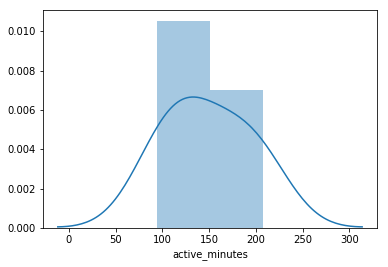

In [323]:
sns.boxplot(df['active_minutes'])
plt.show()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go

# Create random data with numpy
import numpy as np

N = 500
random_x = np.linspace(0, 1, N)
random_y = np.random.randn(N)

# Create a trace
trace = go.Scatter(
    x = df['dt'],
    y = df['active_minutes']
)

data = [trace]

py.iplot(data, filename='basic-line')

In [19]:
df.head()

NameError: name 'df' is not defined

In [ ]:
sns.pointplot(x='date', y='')